# 二分类水果分类器

In [1]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,accuracy_score,recall_score
from sklearn import svm

import glob
import os
import warnings
warnings.filterwarnings('ignore')
dim=100

## 导入图片数据

In [2]:
# 读入部分图片数据以及标签
fruit_images = [] 
labels = [] 
fruit_names=['Pineapple','Apple Braeburn'] 
path_head="Training200\\"
for fruit_name in fruit_names:
    fruit_dir_path = path_head+fruit_name
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [3]:
# 提取标签数据并编号
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v:k for k,v in label_to_id_dict.items()}
id_to_label_dict

{0: 'Apple Braeburn', 1: 'Pineapple'}

In [4]:
# 标签编号
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [5]:
# 绘制图片矩阵
def plot_image_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1 
    fig.savefig("ImageTwo/example1.svg",bbox_inches = 'tight',format='svg')

Apple Braeburn


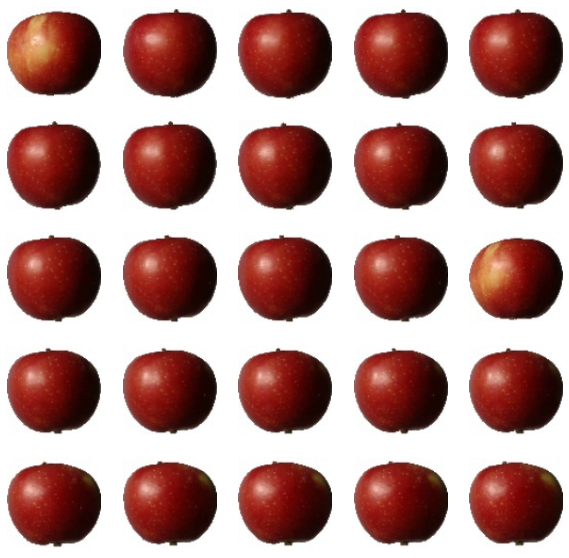

In [6]:
print(id_to_label_dict[label_ids[200]])
plot_image_grid(fruit_images[200:225], 5, 5,figsize=(10,10))

## PCA降维并可视化

### 生成图片向量

In [7]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform([i.flatten() for i in fruit_images])

### 确定特征维数

In [8]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.savefig("ImageTwo/comp.svg",bbox_inches = 'tight',format='svg')
    plt.show()
    
    
def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id])
    return newImage

In [9]:
dim=100
image_id = 0
image = fruit_images[image_id]
X_train = images_scaled

#Compute PCA
X_2 = computePCA(2, X_train,image_id)
X_10 = computePCA(10, X_train,image_id)
X_50 = computePCA(50, X_train,image_id)

In [10]:
#Reshape in order to plot images
X2 = np.reshape(X_2, (dim,dim,3)).astype(int)
X10 = np.reshape(X_10, (dim,dim,3)).astype(int)
X50 = np.reshape(X_50, (dim,dim,3)).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


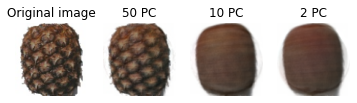

In [11]:
#Plot
showPCA(image, X2, X10, X50)

从上图可以看出降维到50维度以后的图片仍然较好地保留了原图的颜色以及纹理信息，降到10维一下基本分辨不出图像了。这意味我们只需要大约50个维度就可以轻松地对水果进行分类。显然，对于分类算法，更少的数据量也意味着分类的准确性会较低，但是训练时间会更快。

In [12]:
def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]
    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(0,50):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots()
    ind = np.arange(1,51)  
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width)
#     for x, y in zip(ind, var_temp):
#         ax.text(x, y + 1, "{0:.1f}%".format(y), ha='center')
    p2 = ax.plot(ind, var_explained, width, color='r',marker='o') 
#     for x, y in zip(ind, var_explained):
#         ax.text(x, y + 1, "{0:.1f}%".format(y), ha='center')
    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
#     ax.set_xticks(ind)
    
    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()
    plt.savefig("ImageTwo/variance.svg",bbox_inches = 'tight',format='svg')
    plt.show()

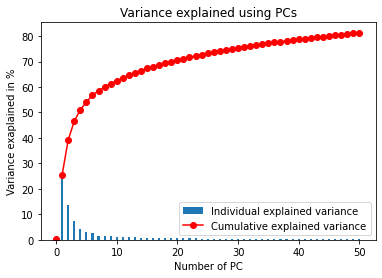

In [13]:
showVariance(X_train)

由上图可以看出，P=10时，特征值对应的累计贡献率已经接近65％，基本能够代表原始图像具有的信息。因此，取前10个主成分组成向量作为果蔬图像的特征向量，作为支持向量机的输入特征。

### PCA降维

In [14]:
pca = PCA(n_components=10)
pca_result = pca.fit_transform(images_scaled)

### 降维可视化

我还将用TSNE方法对主成分分析的结果继续进行降维，这并不是要获得很好的准确性，因为信息量太低，分类器将无法学到太多，而是为了显示决策边界。

In [15]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

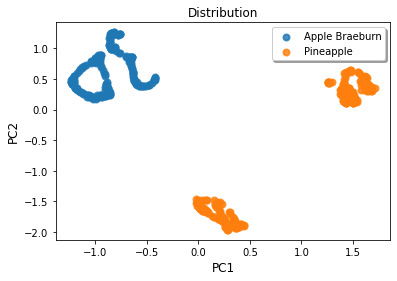

In [16]:
# 分布图
plt.figure()
cmap = plt.cm.get_cmap("jet", len(np.unique(label_ids)))
data_2d = tsne_result_scaled
for i, label_id in enumerate(np.unique(label_ids)):
    plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                data_2d[np.where(label_ids == label_id), 1],
                marker='o',
                cmap=cmap(i),
                linewidth=2,
                alpha=0.8,
                label=id_to_label_dict[label_id])
plt.legend(shadow=True, ncol=1)
plt.xlabel('PC1',fontsize=12)
plt.ylabel('PC2',fontsize=12) 
plt.title('Distribution',fontsize=12)
plt.savefig("ImageTwo/TSNE.svg",bbox_inches = 'tight',format='svg')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

## 线性支持向量机模型

In [18]:
svm_clf = svm.SVC(gamma='auto', kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

#Evaluation
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

Accuracy with SVM: 100.00%


In [19]:
from sklearn.ensemble import RandomForestClassifier
random_state = np.random.RandomState(0) 
forest_clf = RandomForestClassifier(random_state=random_state) # 随机森林

forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

#Evaluation
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with RandomForest: {0:.2f}%".format(precision))

Accuracy with RandomForest: 100.00%


## ROC曲线

In [20]:
data = pd.concat([pd.DataFrame(pca_result), pd.DataFrame(label_ids,columns=['label'])], axis=1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,label
0,-90.454310,64.932652,14.419872,17.280750,-14.462360,3.792420,8.987186,-3.187876,-2.252055,13.771432,1
1,-105.584783,56.928868,13.864369,17.047648,-4.089281,-4.312858,3.198358,-8.900277,-5.974198,3.547399,1
2,-105.630373,57.060434,13.444220,17.099156,-3.144369,-4.786366,3.973283,-8.774713,-5.490592,8.407495,1
3,-104.117939,55.271281,17.300644,12.534809,-3.102016,-6.349415,4.142961,-5.038464,-5.468458,8.167544,1
4,-103.883592,55.599127,11.445743,14.433248,-4.479612,-2.861866,2.571289,-8.004333,0.159750,8.779765,1


In [21]:
x = data.loc[:, data.columns != 'label']
y = data.loc[:,'label']

In [22]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import matplotlib.patches as patches
clf = svm_clf
def ROC_Curve(model):
    cv = StratifiedKFold(n_splits=10,shuffle=False)

    fig1 = plt.figure(figsize=(7,7))
    # plot arrows
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    ax1.add_patch(
        patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
        )
    ax1.add_patch(
        patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
        )
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train,test in cv.split(x,y):
        prediction = model.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.savefig("ImageTwo/ROC_Curve.svg",bbox_inches = 'tight',format='svg')
    plt.show()

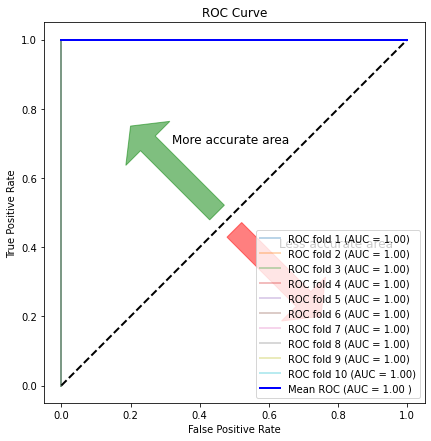

In [23]:
ROC_Curve(svm_clf)

## 在验证数据集上验证

In [24]:
validation_fruit_images = []
validation_labels = [] 
path_head="Test25\\"
for fruit_name in fruit_names:
    fruit_dir_path = path_head+fruit_name
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (dim, dim))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [25]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])
validation_images_scaled = scaler.transform([i.flatten() for i in validation_fruit_images])
validation_pca_result = pca.transform(validation_images_scaled)

In [26]:
test_predictions = svm_clf.predict(validation_pca_result)
precision = accuracy_score(test_predictions, validation_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 100.000000
